### Interactive notebook to demo the interactive PPCA model

In [142]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
# from scipy.stats import invgamma, lognorm
from matplotlib import pyplot as plt
from matplotlib import collections  as mc

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

from IPython.display import display, clear_output
from ipywidgets import Output, Label, VBox, HBox, Button
from ipywidgets import interact

from bqplot import (
    Axis, ColorAxis, LinearScale, LogScale, DateColorScale, OrdinalScale,
    OrdinalColorScale, ColorScale, Scatter, Lines, Figure, Tooltip
)

from ppca_model import MAP
from common.dataset import dataset
import common.plot.simple_plot
from common.plot.simple_plot import SimpleFigure
from common.plot.scatter import imscatter, ellipse_scatter
from common.metric.dr_metrics import DRMetric

dataset.set_data_home('./data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
X_original, X, y = dataset.load_dataset('FASHION100')

In [207]:
# run model the first time to have an init embdedding
losses, z2d_loc, z2d_scale = MAP(X, learning_rate=0.2, n_iters=250)

errors = np.linalg.norm(z2d_scale, axis=1)

K = 10
top_K_ind = np.argpartition(errors, -K)[-K:]

# global interactive data, let's call it 'state'
state = {
    'moved_points': {}, # reset moved points
    'debug_msg': 'Init state',
    'losses': losses,
    'z2d_loc': z2d_loc,
    'z2d_scale': z2d_scale
}

  4%|▍         | 10/250 [00:00<00:02, 97.21it/s]

functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={}, sigma_fix=0.001)


100%|██████████| 250/250 [00:01<00:00, 145.72it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])


In [51]:
# linear interpolate error range to bubble size
errors_as_size = np.interp(errors,
                           [np.min(errors), np.max(errors)],
                           [32, 512])

def log_interp1d(xx, yy, kind='linear'):
    '''https://stackoverflow.com/questions/29346292/logarithmic-interpolation-in-python'''
    import scipy as sp
    import scipy.interpolate
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

# interpolate errors in log scale
errors_as_size = log_interp1d(
    [np.min(errors), np.max(errors)],
    [32, 512]
)(errors)

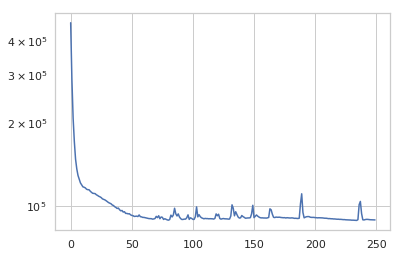

In [205]:
plt.semilogy(losses)

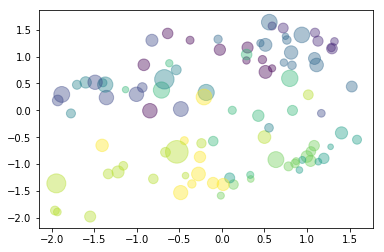

In [52]:
plt.scatter(
    x=z2d_loc[:, 0],
    y=z2d_loc[:, 1],
    c=y,
    s=errors_as_size,
    alpha=0.4
)

In [208]:
def scatter_with_images(ax, z2d, z2d_scale, original_data, labels_true):
    ax.scatter(z2d[:, 0], z2d[:, 1])
    imscatter(ax, z2d, data=original_data, zoom=.75, inverse_cmap=True,
              custom_cmap=None, labels_true=labels_true)
    # ellipse_scatter(ax, z2d, z2d_scale, labels_true)

In [231]:
# create base interactive scatter bqplot
sc_x = LinearScale()
sc_y = LinearScale()
sc_c = OrdinalColorScale(colors=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf'])
sc_size = LinearScale() # LinearScale()

def_tt = Tooltip(fields=['index'], formats=[''])

scatt = Scatter(
    x=[], #z2d_loc[:, 0],
    y=[], #z2d_loc[:, 1],
    color=y,
    size=[], #errors,
    default_size=200, # max size of point
    # names=np.arange(z2d_loc.shape[0]),
    # display_names=False,
    default_opacities=[0.6],
    scales={'x': sc_x, 'y': sc_y, 'color': sc_c, 'size': sc_size},
    enable_move=True,
    tooltip=def_tt,
    unhovered_style={'opacity': 0.3},
    selected=[], # top_K_ind.tolist(),
    selected_style={'stroke': 'red','stroke-width':2, 'opacity':1.0},
)

def reset_scatt():
    scatt.x = []
    scatt.y = []

ax_x = Axis(scale=sc_x, grid_color='#EAECEE', grid_lines='dashed')
ax_y = Axis(scale=sc_y, orientation='vertical', grid_color='#EAECEE', grid_lines='dashed')
ax_c = ColorAxis(scale=sc_c, orientation='vertical', side='right')

fig = Figure(marks=[scatt], axes=[ax_x, ax_y], fig_margin=dict(top=25, bottom=60, left=60, right=60))
fig.background_style = {'fill': 'White'}
fig.layout = {'width': '530px', 'height': '530px'}

In [254]:
# debug label to show some text
lbl = Label(color='green', font_size='18px', value=state['debug_msg'])

def drag_handler(scatter, value):
    print("Drage here: ", value)
    p = value['point']
    point_id = int(value['index'])
    state['moved_points'][point_id] = [float(p['x']), float(p['y'])]
    lbl.value = str(state['moved_points'])

scatt.on_drag_end(drag_handler)

In [255]:
# output widget to hold the static matplotlib plot
out = Output(layout={'border': '0px solid black', 'width': '600px', 'display': 'inline-block'})

# static matplotlib scatter plot with images
_, ax = plt.subplots(1, 1, figsize=(7,7))
plt.close()

In [256]:
# define steps to run model and update graphs in an interactive manner
# all the data are shared between interactive components via the global state

def run_ippca():
    print(state['moved_points'])
    moved_points = state['moved_points']
    sigma_fix = 1e-4
    print('Run interactive PPCA with moved points: ', moved_points, sigma_fix)
    
    losses, z2d_loc, z2d_scale = MAP(X, learning_rate=0.2, n_iters=250,
                                     moved_points=moved_points, sigma_fix=sigma_fix)
    # update global state, note to change each field of the global state dict
    state['moved_points'] = {} # reset moved points
    state['debug_msg'] = 'Init state'
    state['losses'] = losses
    state['z2d_loc'] = z2d_loc
    state['z2d_scale'] = z2d_scale
    
    
def reset_imscatter():
    ax.clear()
    out.clear_output(wait=True)

def update_static_imscatter():
    z2d_loc = state['z2d_loc']
    z2d_scale = state['z2d_scale']
    with out:
        ax.clear()
        scatter_with_images(ax, z2d_loc, z2d_scale, X_original, y)
        clear_output(wait=True)
        plt.tight_layout()
        display(ax.figure)
        plt.close()
        

def update_scatter_bqplot():
    z2d_loc = state['z2d_loc']
    z2d_scale = state['z2d_scale']
    
    errors = np.linalg.norm(z2d_scale, axis=1)
    top_K_ind = np.argpartition(errors, -K)[-K:]
    
    scatt.x = z2d_loc[:,0]
    scatt.y = z2d_loc[:,1]
    scatt.size=errors
    scatt.selected=top_K_ind.tolist()

In [257]:
# button to run iPPCA
btn_run = Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to re-run the model',
    icon='check'
)

btn_reset = Button(description='Reset', button_style='warning')

def rerun_model(btn):
    run_ippca()
    update_static_imscatter()
    update_scatter_bqplot()
    
def reset(_):
    state['moved_points'] = {}
    state['debug_msg'] = 'Reset!'
    lbl.value = 'Reset!'
    reset_imscatter()
    out.clear_output()
    reset_scatt()
    
btn_run.on_click(rerun_model)
btn_reset.on_click(reset)

In [259]:
# feed init data to scatter bqplot and build static imscatter
update_scatter_bqplot()
update_static_imscatter()
update_static_imscatter()

# whole layout
VBox([HBox([out, fig]),
      lbl,
      HBox([btn_run, btn_reset])
     ])

  5%|▍         | 12/250 [00:00<00:02, 117.98it/s]

{}
Run interactive PPCA with moved points:  {} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 137.95it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])


Drage here:  {'event': 'drag_end', 'point': {'x': -0.28048516379961086, 'y': 1.659929341740102}, 'index': 94}
Drage here:  {'event': 'drag_end', 'point': {'x': -1.1570563601155346, 'y': -1.8533108593343144}, 'index': 5}


  4%|▍         | 10/250 [00:00<00:02, 99.64it/s]

{94: [-0.28048516379961086, 1.659929341740102], 5: [-1.1570563601155346, -1.8533108593343144]}
Run interactive PPCA with moved points:  {94: [-0.28048516379961086, 1.659929341740102], 5: [-1.1570563601155346, -1.8533108593343144]} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={94: [-0.28048516379961086, 1.659929341740102], 5: [-1.1570563601155346, -1.8533108593343144]}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 141.66it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])



  4%|▍         | 11/250 [00:00<00:02, 109.96it/s]

{}
Run interactive PPCA with moved points:  {} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 146.74it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])


Drage here:  {'event': 'drag_end', 'point': {'x': -0.20181851797638706, 'y': 1.5524155175277092}, 'index': 6}
Drage here:  {'event': 'drag_end', 'point': {'x': -0.9210564226458627, 'y': -1.6402022854690206}, 'index': 29}


  3%|▎         | 8/250 [00:00<00:03, 77.41it/s]

{6: [-0.20181851797638706, 1.5524155175277092], 29: [-0.9210564226458627, -1.6402022854690206]}
Run interactive PPCA with moved points:  {6: [-0.20181851797638706, 1.5524155175277092], 29: [-0.9210564226458627, -1.6402022854690206]} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={6: [-0.20181851797638706, 1.5524155175277092], 29: [-0.9210564226458627, -1.6402022854690206]}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 147.66it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])


Drage here:  {'event': 'drag_end', 'point': {'x': -1.2768629624208783, 'y': 1.1473598289825577}, 'index': 63}
Drage here:  {'event': 'drag_end', 'point': {'x': 0.8806989672371298, 'y': -1.8621148535307293}, 'index': 50}
Drage here:  {'event': 'drag_end', 'point': {'x': 1.7114419121845497, 'y': 1.1113182160183268}, 'index': 26}


  4%|▍         | 10/250 [00:00<00:02, 95.80it/s]

{63: [-1.2768629624208783, 1.1473598289825577], 50: [0.8806989672371298, -1.8621148535307293], 26: [1.7114419121845497, 1.1113182160183268]}
Run interactive PPCA with moved points:  {63: [-1.2768629624208783, 1.1473598289825577], 50: [0.8806989672371298, -1.8621148535307293], 26: [1.7114419121845497, 1.1113182160183268]} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={63: [-1.2768629624208783, 1.1473598289825577], 50: [0.8806989672371298, -1.8621148535307293], 26: [1.7114419121845497, 1.1113182160183268]}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 147.39it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])



  4%|▍         | 10/250 [00:00<00:02, 97.41it/s]

{}
Run interactive PPCA with moved points:  {} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 143.73it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])


Drage here:  {'event': 'drag_end', 'point': {'x': 0.31513372600479905, 'y': 1.4723777453077356}, 'index': 95}
Drage here:  {'event': 'drag_end', 'point': {'x': -1.1458182678550741, 'y': -0.599711246609362}, 'index': 17}


  4%|▍         | 10/250 [00:00<00:02, 98.23it/s]

{95: [0.31513372600479905, 1.4723777453077356], 17: [-1.1458182678550741, -0.599711246609362]}
Run interactive PPCA with moved points:  {95: [0.31513372600479905, 1.4723777453077356], 17: [-1.1458182678550741, -0.599711246609362]} 0.0001
functools.partial(<function ppca_model at 0x7f7b1cd8dbf8>, M=2, moved_points={95: [0.31513372600479905, 1.4723777453077356], 17: [-1.1458182678550741, -0.599711246609362]}, sigma_fix=0.0001)


100%|██████████| 250/250 [00:01<00:00, 145.30it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])
